In [35]:
import networkx as nx
import csv
import numpy as np
from collections import Counter
import collections
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import powerlaw as pl
import random
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

plt.rcParams['figure.figsize']=[15,7]

In [62]:
g = nx.read_edgelist("./Edgelists/complete_networld_cap.edgelist", create_using = nx.DiGraph())

In [37]:
def random_walk(g):
    edge_count = {}
    for i in range(5000):
        start = str(np.random.randint(1,12982))
        status = True
        while status == True:
            for j in range(1,9):
                node_neighbors = list(g.neighbors(start))
                if len(node_neighbors) != 0:
                    N = random.choice(list(g.neighbors(start)))
                    pair = start + ' ' + N

                    try: 
                        edge_count[pair] += 1
                    except KeyError as e:
                        edge_count[pair] = 1   
                    start = N

                else:
                    status = False
            status = False 
    return edge_count

In [38]:
def plotnormal(g):
    walk = random_walk(g)
    degreesdistribution = dict(Counter(walk.values()))
#    print(degreesdistribution)
    totaledges = sum(degreesdistribution.values())
    length = len(degreesdistribution)
    new = {}
    for key in degreesdistribution:
        new[key] = degreesdistribution[key]/key
    
#        new[key] = degreesdistribution[key]/totaledges
#        degreesdistribution[key] = 1/degreesdistribution[key]
    plt.subplot(2,1,1)
    plt.scatter(new.keys(),new.values())
    plt.title("Normalized")
    plt.subplot(2,1,2)
    plt.scatter(degreesdistribution.keys(),degreesdistribution.values())
    plt.title("Not Normalized")
    plt.show()
plotnormal(g)

TypeError: float() argument must be a string or a number, not 'dict_values'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f749eb1b7b8> (for post_execute):


TypeError: float() argument must be a string or a number, not 'dict_values'

TypeError: float() argument must be a string or a number, not 'dict_values'

In [ ]:
def graph_info(g):
    print("# of nodes: %d" % g.number_of_nodes())
    print("# of edges: %d" % g.number_of_edges())
    print("# of selfloops: %d" % g.number_of_selfloops())
    print("Cycle in g:")
    print(nx.find_cycle(g))
    print("G is a DAG: %s" % nx.is_directed_acyclic_graph(g))
    print("G is a tree: %s" % nx.is_tree(g))
    
    print("G's density: %1.2f%%" % (100 * nx.density(g))) #density = number_of_edges / max_theoretical_number_of_edges
    print("G's reciprocity: %1.2f%%" % (100 * nx.reciprocity(g))) #Reciprocity: share of connections going both ways in directed graph
    print("G's clustering coefficient = %s" % nx.transitivity(g))
    print("G is a strongly connected graph: %s" % nx.is_strongly_connected(g))
    print("G is a weakly connected graph: %s" % nx.is_weakly_connected(g))
    
    max_weakly_cc = max(nx.weakly_connected_components(g), key=len)
    min_weakly_cc = min(nx.weakly_connected_components(g), key=len)
    number_weakly_cc = [len(c) for c in sorted(nx.weakly_connected_components(g), key=len, reverse=True)]
    
    print("Biggest weakly connected component: %s" % max_weakly_cc)
    print("Smallest weakly connected component: %s" % min_weakly_cc)
    print("# of nodes in the connected components in {0}: {1}".format("G",number_weakly_cc))

In [ ]:
def degree_analysis(g):
    degree = nx.degree(g)
    degree_count = Counter(dict(degree).values())
    degree_df = pd.DataFrame(list(degree_count.items()), columns = ('k', 'count'))
    degree_df = degree_df.sort_values(by='k')
    degree_df['p(k)'] = degree_df['count']/degree_df['count'].sum()
    degree_df['log_k']= np.log10(degree_df['k'])
    degree_df['log_p(k)']= np.log10(degree_df['p(k)'])
    print(degree_df.head())
    
    plt.clf()
    plt.subplot(1,2,1)
    plt.title('Linear Scale')
    plt.scatter(degree_df['k'], degree_df['p(k)'])


    plt.subplot(1,2,2)
    plt.title('Logarithmic Scale')
    plt.scatter(degree_df['log_k'], degree_df['log_p(k)']) #Have a thoughtfull look at the x labels (these are powers [2 means 10^2, 3 means 10^3])
    #another way to plot in the log_log scale without calculating the logs is to do the following
    #plt.loglog(degree_df['k'], degree_df['p(k)'])
    plt.show()
    
    degree_df = degree_df.sort_values(by='k', ascending=False)
    degree_df['comsum_p(k)'] = degree_df['p(k)'].cumsum()
    degree_df['log_comsum_p(k)'] = np.log10(degree_df['comsum_p(k)'])
    print(degree_df.head())
    
    plt.clf()
    plt.subplot(1,2,1)
    plt.title("Linear Scale")
    plt.scatter(degree_df['k'], degree_df['comsum_p(k)'])

    plt.subplot(1,2,2)
    plt.title("Logarithmic Scale")
    plt.scatter(degree_df['log_k'],degree_df['log_comsum_p(k)'])
    #try also
    #plt.loglog(degree_df['k'], degree_df['comsum_p(k)'])
    plt.show()
    
    slope,intercept,r_value,p_value,std_error = linregress(np.log10(degree_df['k']),np.log10(degree_df['comsum_p(k)']))
    print(r_value,p_value)
    
    #Let us plot both our distribtuion and the straight line returned by the linear regression
    plt.clf()
    plt.scatter(degree_df['log_k'],degree_df['log_comsum_p(k)'], label="degree distribution")

    plt.plot(degree_df['log_k'],intercept+slope*degree_df['log_k'], 'r--', label="linear regression fit")
    plt.legend()
    plt.show()

In [ ]:
def powerlaw(g):

    degrees= sorted(dict(g.degree()).values())

    results = pl.Fit(degrees, discrete=True)

    #First check whether power_law or expoenential distribution is preferred, then whether power_law or lognormal is preferred
    R, p = results.distribution_compare('power_law', 'exponential') #Here we are checking which of those two functions can be a better fit to our distribtuin ('exponential' vs 'power law')
    print(R, p)
    if (R > 0) and (p < .05): #[This means that the power law assumption is preffered over the exponential, but still we have to do another test to have our final claim]
        R, p = results.distribution_compare('power_law', 'lognormal') #Here we are checking which of those two functions can be a better fit to our distribtuin ('lognormal' vs 'power law')
        print(R, p)
        if p < .05: #This means that result we get is significant (statistically) and we can trust it.
            if R > 0:
                print("Powerlaw hypothesis preferred (p = %1.4f, CDF exponent = %1.4f)" % (p, results.power_law.alpha - 1)) # The CDF's alpha is the PMF's alpha minus one. The powerlaw package gives us the PMF's alpha.
            else:
                print("Lognormal hypothesis preferred (p = %1.4f, mu = %1.4f, sigma = %1.4f)" % (p, results.lognormal.mu, results.lognormal.sigma))
        else: #We can not trust the result, and we are not able to differenciate even if R > 0 
            print("Powerlaw and Lognormal are indistinguishable hypotesis.")
    else:
        print("We cannot rule out an exponential fit. Definitely not a power law.")

        

In [39]:
def degree(g):
    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    Gcc = sorted(nx.weakly_connected_component_subgraphs(g), key=len, reverse=True)[0]
    pos = nx.spring_layout(g)
    plt.axis('off')
    nx.draw_networkx_nodes(g, pos, node_size=20)
    nx.draw_networkx_edges(g, pos, alpha=0.4)

    plt.show()

In [40]:
def centrality_measures(g):
    deg_cen = nx.degree_centrality(g)
    bet_cen = nx.betweenness_centrality(g)
    close_cen = nx.closeness_centrality(g)
    pagerank_cen = nx.pagerank(g)
    
    pos = nx.spring_layout(g,iterations=100)
    plt.subplot(1,4,1)
    plt.title("Degree")
    nx.draw_networkx(g,
                pos=pos,
                node_size=[size*1000 for size in deg_cen.values()],
                with_labels = False,
                width=0.1)
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.title("Between Centrality")
    nx.draw_networkx(g,
                pos=pos,
                node_size=[size*1000 for size in bet_cen.values()],
                with_labels = False,
                width=0.1)
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.title("Closeness Centrality")
    nx.draw_networkx(g,
                pos=pos,
                node_size=[size*1000 for size in close_cen.values()],
                with_labels = False,
                width=0.1)
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.title("Page Rank")
    nx.draw_networkx(g,
                pos=pos,
                node_size=[size*1000 for size in pagerank_cen.values()],
                with_labels = False,
                width=0.1)


    plt.axis('off')
    plt.show()

In [44]:
def node_cores(g):
    pos = nx.spring_layout(g,iterations=100)
    deg_cen = nx.degree_centrality(g)
    nodes_cores = nx.core_number(g)

    #nx.draw_networkx(g,
    #            pos=pos,
    #            node_color = 'red',
    #            node_size = [size*1000 for size in deg_cen.values()],
    #            with_labels=True,
    #            width=0.1,
    #            labels=nodes_cores)
    #plt.axis('off')
    #plt.show()
    #plt.close
    
    return nodes_cores, deg_cen

In [45]:
g = nx.read_edgelist("./Edgelists/friedrichshain_center_dg_cap.edgelist", create_using = nx.DiGraph())

In [61]:
for i, key in enumerate(nodes_cores):
    print(nodes_cores[val])

4
4
2
3
4
2
2
2
4
4
2
4
3
4
3
4
4
2
4
4
3
2
2
4
4
2
2
2
4
2
2
2
4
4
3
2
3
4
3
3
4
4
2
2
4
4
3
4
2
4
4
4
4
4
4
4
2
3
3
2
3
4
4
3
2
4
4
2
4
4
2
2
2
2
4
3
4
2
4
4
3
2
4
3
4
4
4
3
1
2
4
1
4
2
4
4
4
3
4
4
4
3
3
2
4
4
4
3
2
4
2
2
4
4
2
3
2
4
4
3
4
3
2
4
2
3
4
2
2
4
4
3
4
2
4
4
4
2
4
2
4
3
1
2
2
4
2
2
4
1
2
4
2
2
2
2
4
2
2
2
3
3
4
4
2
3
4
3
4
4
3
4
2
4
2
4
3
3
4
1
3
4
3
4
2
2
2
2
2
3
4
2
2
4
3
2
2
4
2
1
3
2
4
4
3
4
4
2
4
4
4
2
3
2
4
3
3
2
4
2
2
1
4
4


In [54]:
nodes_cores

{'1': 4,
 '10': 4,
 '100': 4,
 '101': 4,
 '102': 2,
 '103': 3,
 '104': 3,
 '105': 2,
 '106': 4,
 '107': 4,
 '108': 2,
 '109': 3,
 '11': 4,
 '110': 4,
 '111': 4,
 '112': 2,
 '113': 3,
 '114': 4,
 '115': 2,
 '116': 4,
 '117': 4,
 '118': 2,
 '119': 4,
 '12': 4,
 '120': 4,
 '121': 3,
 '122': 2,
 '123': 4,
 '124': 4,
 '125': 3,
 '126': 4,
 '127': 4,
 '128': 4,
 '129': 2,
 '13': 4,
 '130': 1,
 '131': 1,
 '132': 2,
 '133': 2,
 '134': 4,
 '135': 2,
 '136': 4,
 '137': 2,
 '138': 4,
 '139': 4,
 '14': 3,
 '140': 3,
 '141': 4,
 '142': 4,
 '143': 4,
 '144': 4,
 '145': 4,
 '146': 4,
 '147': 2,
 '148': 2,
 '149': 2,
 '15': 4,
 '150': 2,
 '151': 2,
 '152': 2,
 '153': 2,
 '154': 2,
 '155': 2,
 '156': 2,
 '157': 3,
 '158': 2,
 '159': 4,
 '16': 4,
 '160': 4,
 '161': 4,
 '162': 2,
 '163': 2,
 '164': 3,
 '165': 3,
 '166': 3,
 '167': 3,
 '168': 2,
 '169': 2,
 '17': 4,
 '170': 2,
 '171': 2,
 '172': 2,
 '173': 3,
 '174': 2,
 '175': 2,
 '176': 2,
 '177': 2,
 '178': 2,
 '179': 4,
 '18': 4,
 '180': 2,
 '181': 2,

In [42]:
def avg_shortests_path_hist(g):
    avg_path_length = []
    for n in g.nodes():
        shortes_paths_lengths = nx.single_source_shortest_path_length(g,n).values()
        #print(shortes_paths_lengths)
        avg_path_length.append(sum(shortes_paths_lengths)/(len(shortes_paths_lengths)))
    plt.clf()
    plt.hist(avg_path_length) #avg degree of separation
    plt.axvline(nx.average_shortest_path_length(g), color='red', linestyle='dashed')
    plt.show()

# Berlin Analysis

In [63]:
graph_info(g)

# of nodes: 12981
# of edges: 33217
# of selfloops: 0
Cycle in g:
[('10415', '10416'), ('10416', '10415')]
G is a DAG: False
G is a tree: False
G's density: 0.02%
G's reciprocity: 49.78%
G's clustering coefficient = 0.10997435000582954
G is a strongly connected graph: False
G is a weakly connected graph: True
Biggest weakly connected component: {'10415', '12556', '8992', '3710', '8744', '3190', '2396', '10323', '8731', '1772', '7738', '7755', '10020', '9758', '12725', '2818', '6367', '6064', '12111', '12428', '2016', '12861', '10466', '8567', '10755', '3878', '921', '2540', '5987', '5937', '6229', '545', '11750', '9865', '11374', '5001', '2487', '11893', '6321', '310', '546', '2521', '1803', '4308', '12370', '8035', '8925', '4224', '142', '3317', '2023', '5424', '9308', '1610', '6547', '980', '4545', '7946', '6863', '3158', '2733', '7052', '10508', '11446', '11828', '6658', '9621', '10001', '3935', '7102', '10301', '12807', '7434', '10823', '12103', '2769', '9604', '7902', '2791', '120

   k  count      p(k)     log_k  log_p(k)
0  1    106  0.008166  0.000000 -2.088002
1  2   3513  0.270626  0.301030 -0.567630
2  3   1050  0.080887  0.477121 -1.092119
3  4   3996  0.307835  0.602060 -0.511683
4  5    454  0.034974  0.698970 -1.456252


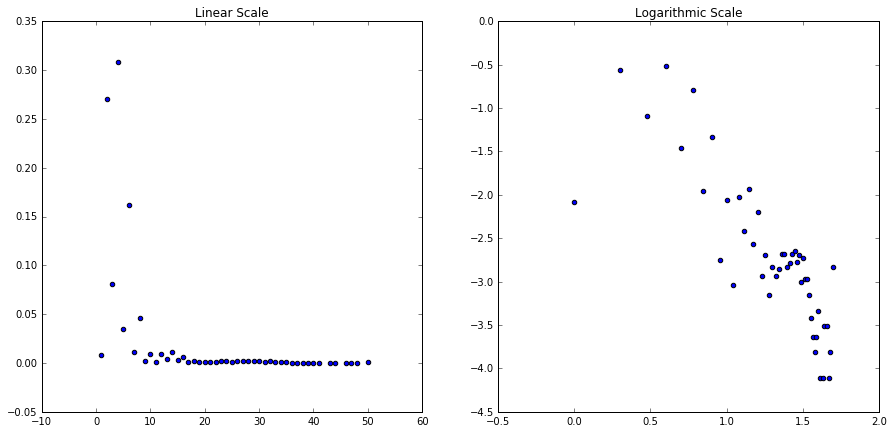

     k  count      p(k)     log_k  log_p(k)  comsum_p(k)  log_comsum_p(k)
46  50     19  0.001464  1.698970 -2.834555     0.001464        -2.834555
45  48      2  0.000154  1.681241 -3.812278     0.001618        -2.791089
44  47      1  0.000077  1.672098 -4.113308     0.001695        -2.770885
43  46      4  0.000308  1.662758 -3.511248     0.002003        -2.698335
42  44      4  0.000308  1.643453 -3.511248     0.002311        -2.636187


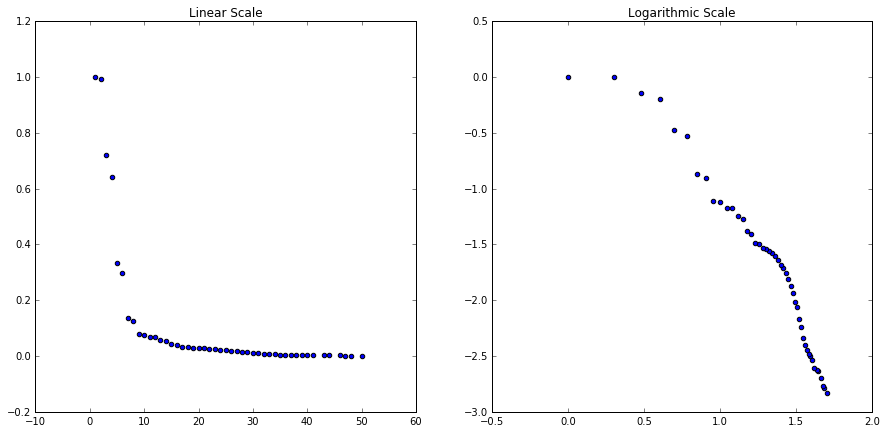

-0.9594115674547901 2.249055721463572e-26


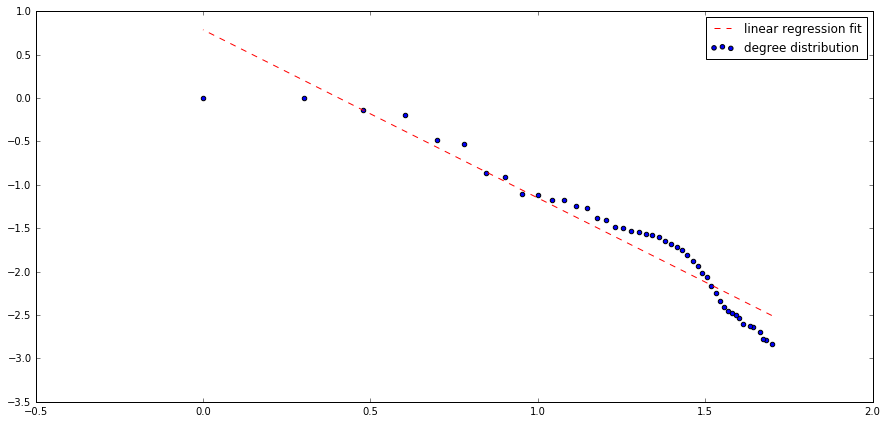

In [25]:
degree_analysis(g)

In [26]:
powerlaw(g)

-1.8849500894272322 0.19830634735569952
We cannot rule out an exponential fit. Definitely not a power law.


Calculating best minimal value for power law fit


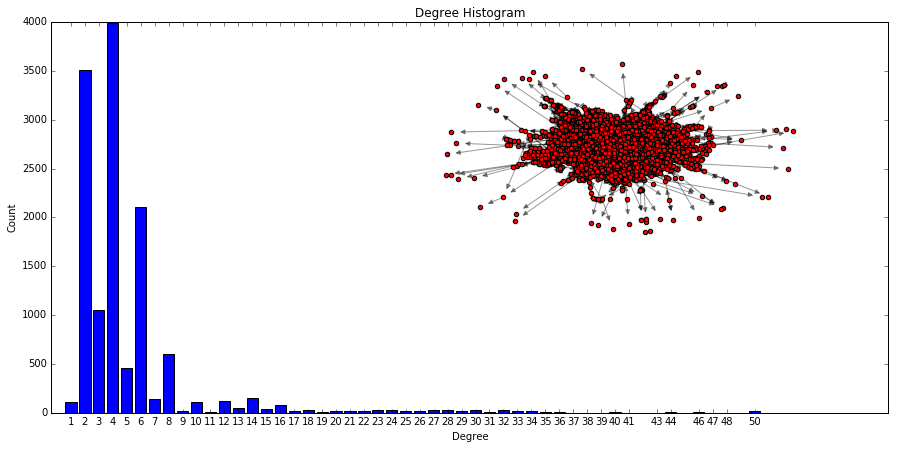

In [27]:
degree(g)

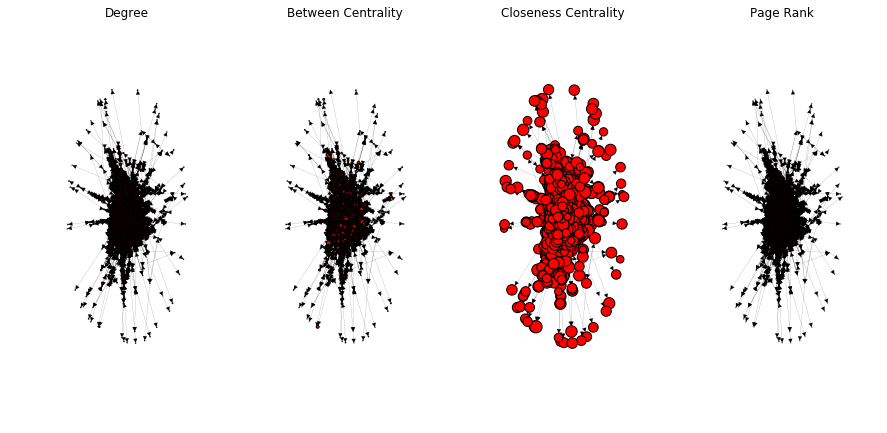

In [30]:
centrality_measures(g)

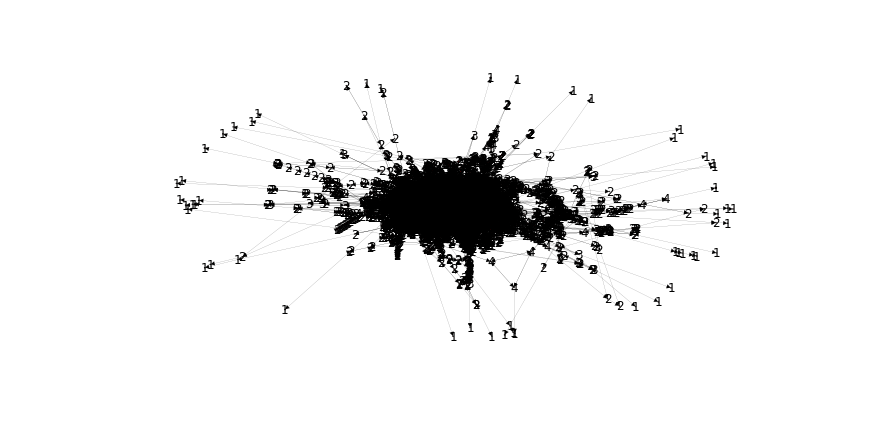

In [31]:
node_cores(g)

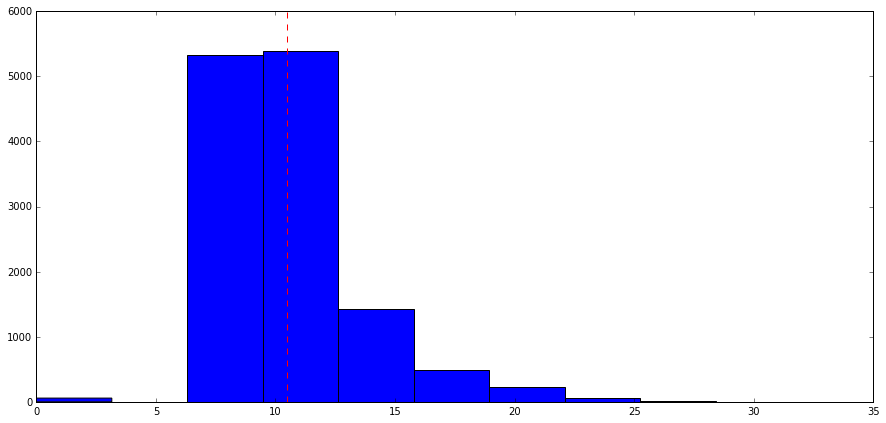

In [32]:
avg_shortests_path_hist(g)